In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [9]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [10]:
try:
    project_root = Path.cwd().parent
    features_path = project_root / "data" / "processed" / "features_regresion.csv"
    df_reg = pd.read_csv(features_path)
    print(f"DataFrame para regresión cargado desde: {features_path}")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en: {features_path}")
    df_reg = None

DataFrame para regresión cargado desde: /Users/edusant/Desktop/personal/blue_tab/proyecto-riesgo-crediticio/data/processed/features_regresion.csv


In [11]:
if df_reg is not None:
    # Seleccionar solo columnas numéricas y definir X e y.
    # Se excluye 'ID' y otras columnas no predictivas que pudieran existir.
    X = df_reg.select_dtypes(include=np.number).drop(columns=['pay_amt_june', 'ID'], errors='ignore')
    y = df_reg['pay_amt_june']

    # División de datos.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Transformación logarítmica de la variable objetivo para estabilizar la varianza.
    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # Escalado de características.
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("\n--- Preparación de datos completada ---")
    print(f"Forma de X_train: {X_train_scaled.shape}")
    print(f"Forma de X_test: {X_test_scaled.shape}")


--- Preparación de datos completada ---
Forma de X_train: (24000, 26)
Forma de X_test: (6000, 26)


In [12]:
def train_and_evaluate_regressor(X_train, y_train, X_test, y_test, model, model_name):
    """
    Entrena un modelo de regresión, realiza predicciones y devuelve las métricas.
    Maneja la transformación inversa si la variable objetivo fue transformada.
    """
    # Entrenamiento
    model.fit(X_train, y_train)
    
    # Predicción en la escala logarítmica
    y_pred_log = model.predict(X_test)
    
    # Transformación inversa para obtener predicciones en la escala original
    y_pred_original = np.expm1(y_pred_log)
    
    # Cálculo de métricas en la escala original
    r2 = r2_score(y_test, y_pred_original)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_original))
    mae = mean_absolute_error(y_test, y_pred_original)
    
    print(f"\n--- Resultados para {model_name} ---")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    metrics = {
        'Model': model_name,
        'R2 Score': r2,
        'RMSE': rmse,
        'MAE': mae
    }
    
    return metrics, y_pred_original

In [13]:
if 'X_train_scaled' in locals():
    # Definir los modelos a probar
    models = {
        "Regresión Lineal": LinearRegression(),
        "Regresión de Huber": HuberRegressor(max_iter=1000),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
    }
    
    results = []
    predictions = {}

    for name, model in models.items():
        metrics, y_pred = train_and_evaluate_regressor(X_train_scaled, y_train_log, X_test_scaled, y_test, model, name)
        results.append(metrics)
        predictions[name] = y_pred
        
    # 5.1. Tabla Comparativa de Resultados
    results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)
    
    print("\n--- Tabla Comparativa de Rendimiento de Modelos de Regresión ---")
    display(results_df)


--- Resultados para Regresión Lineal ---
R² Score: -115746.5925
RMSE: 4353059.7701
MAE: 104903.4699

--- Resultados para Regresión de Huber ---
R² Score: -613781.8376
RMSE: 10024114.4692
MAE: 168684.1601

--- Resultados para Random Forest ---
R² Score: 0.7540
RMSE: 6346.1134
MAE: 1394.6020

--- Resultados para XGBoost ---
R² Score: 0.5131
RMSE: 8928.3396
MAE: 2041.8311

--- Tabla Comparativa de Rendimiento de Modelos de Regresión ---


,Model,R2 Score,RMSE,MAE
2,Random Forest,0.753998,6.346113e+03,1394.602023
3,XGBoost,0.513073,8.928340e+03,2041.831055
0,Regresión Lineal,-115746.592457,4.353060e+06,104903.469934
1,Regresión de Huber,-613781.837551,1.002411e+07,168684.160070



--- Análisis Profundo del Mejor Modelo: Random Forest ---


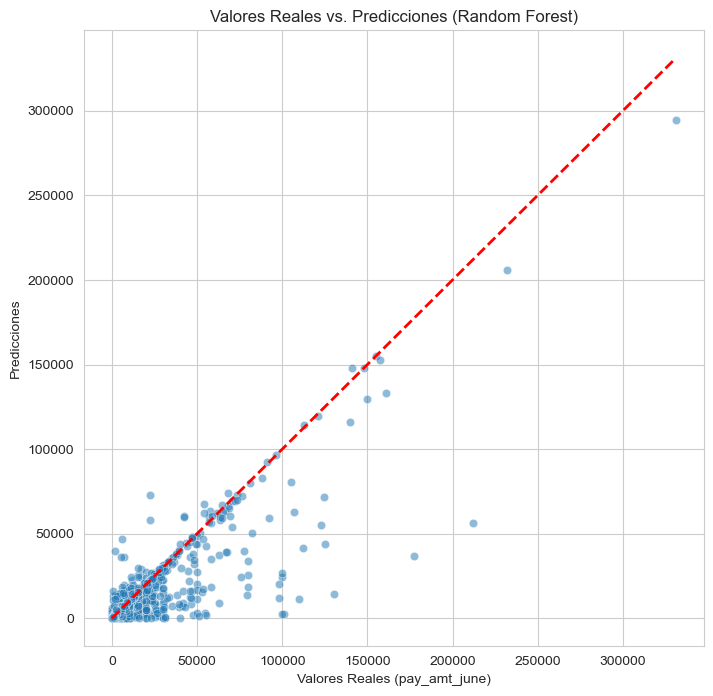

/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_42105/3974899225.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')


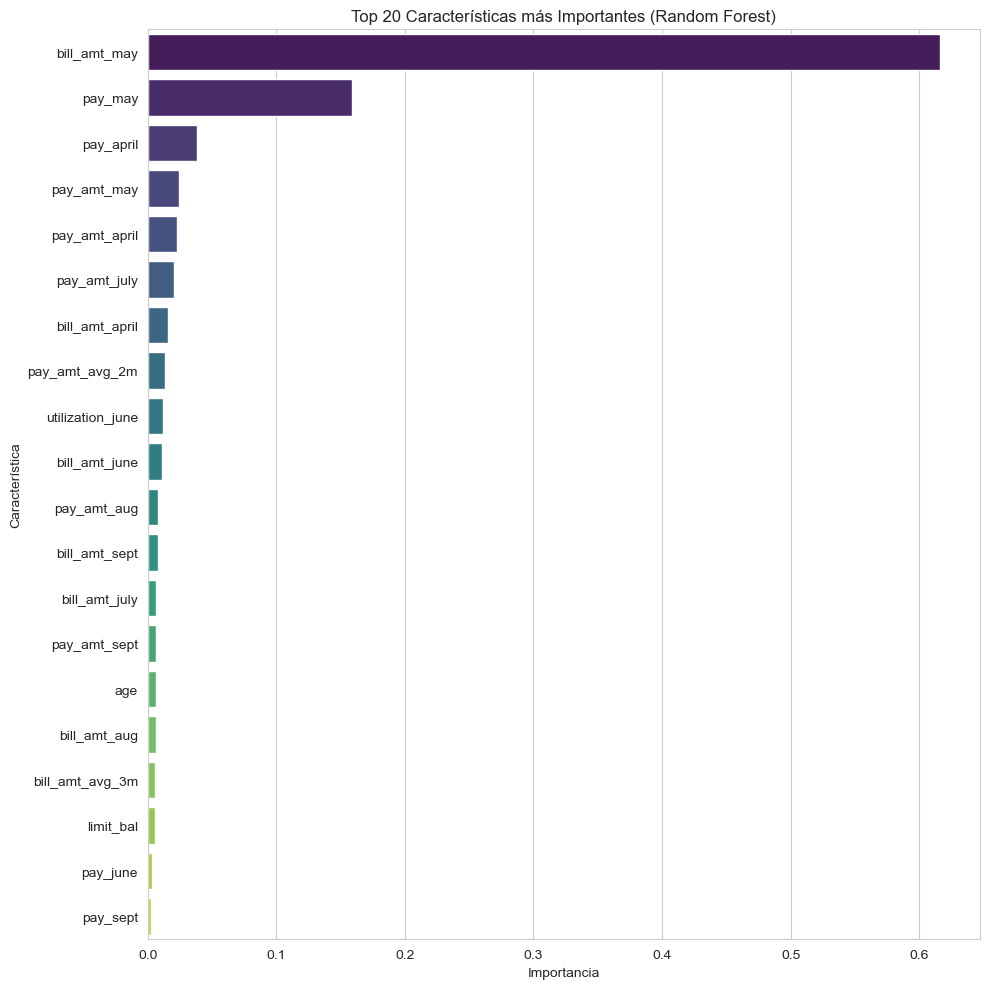

In [14]:
if 'results_df' in locals() and not results_df.empty:
    best_model_name = results_df.iloc[0]['Model']
    print(f"\n--- Análisis Profundo del Mejor Modelo: {best_model_name} ---")
    
    # 6.1. Gráfico de Predicciones vs. Valores Reales
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_test, y=predictions[best_model_name], alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
    plt.title(f'Valores Reales vs. Predicciones ({best_model_name})')
    plt.xlabel('Valores Reales (pay_amt_june)')
    plt.ylabel('Predicciones')
    plt.show()
    
    # 6.2. Importancia de Características (si el modelo lo permite)
    best_model_instance = models[best_model_name]
    if hasattr(best_model_instance, 'feature_importances_'):
        importances = best_model_instance.feature_importances_
        feature_names = X.columns
        
        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
        
        plt.figure(figsize=(10, 10))
        sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
        plt.title(f'Top 20 Características más Importantes ({best_model_name})')
        plt.xlabel('Importancia')
        plt.ylabel('Característica')
        plt.tight_layout()
        plt.show()